In [1]:
import copy
import folium
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import networkx as nx
import numpy as np
import pandas as pd
from os import path
import pickle
import random
from timeit import default_timer as timer

# From local files:
from hasgrid import HashGrid
from helpfunctions import get_rnd_graph, plot_Graph, plot_log, path_to_list
from helpfunctions import get_rnd_segment, diff_E, move_segment, get_length

In [2]:
# DATA sources
#https://simplemaps.com/data/fi-cities

cities = pd.read_csv(path.join('.','data','fi.csv'), usecols=['city', 'lat', 'lng'])
cities.head()

,city,lat,lng
0,Helsinki,60.1756,24.9342
1,Espoo,60.2100,24.6600
2,Tampere,61.4981,23.7608
3,Vantaa,60.3000,25.0333
4,Oulu,65.0142,25.4719


In [3]:
# Inspect the city locations on a map
cities_map = folium.Map()

# Add markers:
for index, row in cities.iterrows():
    marker = folium.Marker(location=(row['lat'], row['lng']), popup=row['city'])
    marker.add_to(cities_map)

# Crop the map\\
sw = cities[['lat', 'lng']].min().values.tolist()
ne = cities[['lat', 'lng']].max().values.tolist()
cities_map.fit_bounds([sw, ne]) 
    
cities_map

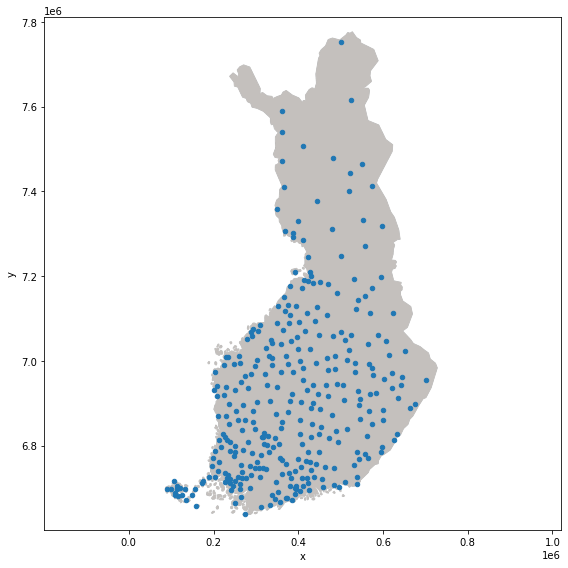

In [4]:
# Recreate the above (roughly) using flattened coorinates and a siluette of Finland
from pyproj import Transformer
t = Transformer.from_crs("epsg:4326", "epsg:3067") # From global Geodetic System to Finnish system

cities[['x','y']] = cities.apply(lambda r: t.transform(r['lat'], r['lng']), axis=1, result_type='expand')

# Original image source https://fi.wikipedia.org/wiki/Tiedosto:Suomi.karttapohja.svg
shiluette = plt.imread(path.join('.', 'media', 'map.png'))
fig, ax = plt.subplots(figsize=(8, 8))
extent = [-.030e6, .850e6, 6.612e6, 7.8e6] # eyeballed offset
plt.imshow(shiluette, extent=extent)
cities.plot.scatter('x', 'y', ax=ax)
ax.axis('equal')
plt.tight_layout()

In [5]:
# Add cities as nodes (in networkx Graph)
node_list = [] # (ind, {'pos':np.array(x,y)}) elements
for ind, city in cities.iterrows():
    xy = np.asarray([city['x'], city['y']])
    node_list.append((ind, {'pos': xy}))


G = nx.Graph()
G.add_nodes_from(node_list)

# Connect cities, i.e. nodes, in the same order as they were listed in cities dataframe
G.add_edges_from([(n, (n + 1) % len(cities)) for n in range(len(cities))])

# Add usefull tracking info to the Graph
G.graph["length"] = get_length(G)
G.graph["N"] = len(cities)
G.graph["hash_grid"] = HashGrid(G)

# Let's keep a copy of the original so we can reset the animation
G_original = copy.deepcopy(G)

In [6]:
def update(i):
    global G_best
    ### ANNEALING ###
    temp = Tmax + i * cooling_rate
    for walk in range(N_walks):
        # 1. Make a random change:
        N_seg = 1 + np.random.binomial(N_seg_max - 1, 0.5)
        permutation = get_rnd_segment(G, N_seg, reach=2 * k_b * temp)
        # 2. Calculate the energy change
        dE = diff_E(G, *permutation)
        # 3. p("Accept change")=the Boltzmann's factor
        if random.random() < np.exp(-1 * dE / (k_b * temp)):
            move_segment(G, *permutation)
            G.graph["length"] += dE
            if G.graph["length"] <= G_best.graph["length"]:
                G_best = G.copy()
    
    ### PLOTTING ###
    track_t.append(temp)
    track_l.append(G.graph["length"] / 1000)
   

    # Graph
    plot_Graph(ax1, G,T=temp, T_range=(Tmin, Tmax),N_walk=walk)
    
    # Shiluette
    ax1.imshow(shiluette, extent=extent)
    # Progress
    plot_log(axs2, temps=track_t, lengths=track_l, T_range=(Tmin, Tmax), k_b=k_b, N_cities=len(cities))
    if plot_realtime:
        display(fig)
        clear_output(wait=True)
    
    

In [7]:
""" Options For Visuals """
seed =123
plot_realtime = False


""" Options For Simulation """
N_seg_max = 5  # How many points to permute at once.
N_temps = 5000
Tmax = 400
Tmin = 1
cooling_rate = -(Tmax - Tmin) / N_temps
N_walks = 10000

""" Initializations """
G_best = copy.deepcopy(G)
#  Available error per Kelvin -> avg_error / T_max is a good estimate.
k_b = G.graph["length"] / G.graph['N'] / 2 / Tmax


In [8]:
""" Initalize Graph and tracking """ 
random.seed(seed)
G = G_original.copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
axs2 = (ax2, ax2.twinx(), ax2.twiny())
track_t, track_l = [], []  # To log progress
#track_t.append(Tmax)
#track_l.append(G.graph["length"]/1000)


""" Animate """
rc("animation", html="jshtml")  # HTML(anim.to_jshtml()) by default
rc("animation", embed_limit = 2**128)
#rcParams['animation.embed_limit'] = 2**128
anim = animation.FuncAnimation(
    fig, update, frames=int(-1 * (Tmax - Tmin) / cooling_rate), interval=100
)
display(anim)
plt.close(fig)

In [9]:
""" Initalize Graph and tracking """
np.random.seed(seed)
random.seed(seed)
G = copy.deepcopy(G_original)
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
track_t, track_l = [], []  # To log progress
#track_t.append(Tmax)
#track_l.append(G.graph["length"]/1000)

#store as gif
writergif = animation.PillowWriter(fps=30) 
anim.save(path.join('.', 'media', 'roadtrip.gif'), writer=writergif)

In [10]:
# Store as mp4. Usefull tutorials
# https://www.wikihow.com/Install-FFmpeg-on-Windows
# https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/

""" Initalize Graph and tracking """
np.random.seed(seed)
random.seed(seed)
G = copy.deepcopy(G_original)
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
track_t, track_l = [], []  # To log progress
#track_t.append(Tmax)
#track_l.append(G.graph["length"]/1000)

mpl.rcParams['animation.ffmpeg_path'] = r'C:\\ffmpeg\\bin\\ffmpeg.exe'
writervideo = animation.FFMpegWriter(fps=30) 

anim.save(path.join('.', 'media', 'roadtrip.mp4'), writer=writervideo)

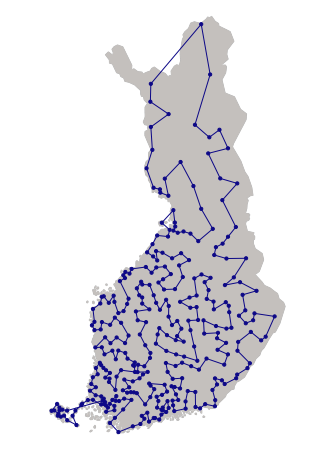

In [11]:
# Plot the best so far
fig, ax = plt.subplots(figsize=(8, 8))

plot_Graph(ax, G_best, Tmin)
plt.imshow(shiluette, extent=extent)
plt.show()


In [12]:
# Save the path
best = f"best_route_{int(G_best.graph['length'])}.p"
latest = f"latest_route_{int(G.graph['length'])}.p"
pickle.dump(path_to_list(G_best), open(path.join('.', 'data', best), "wb" ), protocol=1 )
pickle.dump(path_to_list(G), open(path.join('.', 'data', latest), "wb" ), protocol=1 )

In [14]:
print(best)
print(latest)

best_route_8545015.p
latest_route_8706202.p
